In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_dog, blob_log, blob_doh
import cv2
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from skimage.exposure import rescale_intensity, adjust_gamma
from matplotlib.collections import LineCollection
from tqdm import tqdm
from scipy.ndimage import binary_erosion, binary_dilation
from math import hypot
import warnings
import pickle
from diffsims.libraries.diffraction_library import load_DiffractionLibrary
from pyxem.utils import indexation_utils as iutls
from orix.quaternion import Misorientation
plt.rcParams["font.family"] = "Arial"
warnings.filterwarnings(action='once')
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
%matplotlib notebook


def subtract_background_dog(z, sigma_min, sigma_max):        ###################### background subtract for diffraction image
    blur_max = gaussian_filter(z, sigma_max)
    blur_min = gaussian_filter(z, sigma_min)
    return np.maximum(np.where(blur_min > blur_max, z, 0) - blur_max, 0)
    
import skimage.filters as skifi

#
# Processing a single image
#
def process_image(image, threshold = 1, gamma = 0.2):                # Gamma correction
    # map the minimum to 0
    image = image - image.min()
    # remove the entire diffuse background
    image = subtract_background_dog(image, 0.5, 10)
    # smooth the image
    image = gaussian_filter(image, sigma=1.5)
    # remove low intensity pixels
    image[image < threshold] = 0
    # change the gamma of the images
    image = adjust_gamma(image, gamma)
    # remap intensities to 0-1 range
    image = rescale_intensity(image)
    return image

num_mapping = 3
    
class grain:
    def __init__(self, load_map, diff_pattern, contour = False, loc = False, area=False, central_diff_pattern = -1, index = -1):
        if load_map is not None:
            self.load_map = load_map
            self.origin_loc = ndimage.measurements.center_of_mass(load_map)
        if diff_pattern is not None:
            self.diff_pattern = diff_pattern
        if contour:
            self.init_contour = contour
        else:
            if load_map is not None:
                contours, hierarchy = cv2.findContours(np.uint8(binary_erosion(load_map,iterations=1)), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
                self.init_contour = contours
        if loc:
            self.loc = loc
        else:
            self.loc = self.origin_loc
        
        if area:
            self.area = area
        else:
            self.area = load_map.sum() # nm^2
        self.index = index # keep all 0.9*max_cross_corr, in sequence of cross_corr
        self.central_diff_pattern = central_diff_pattern

        
    def update_diff_pattern_center_region(self, original_dataset, dilation = 2):
        loc = np.array(self.origin_loc).astype(int)
        start_x, start_y = max(0, int(loc[0]-dilation)), max(0, int(loc[1]-dilation))
        end_x, end_y = min(400, int(loc[0]+dilation+1)), min(400, int(loc[1]+dilation+1))
        self.central_diff_pattern = original_dataset.inav[start_y:end_y,start_x:end_x].mean(axis = (0,1))
        self.central_diff_patterns = original_dataset.inav[start_y:end_y,start_x:end_x]
        
    def indexation(self, index_map, filter_misori_threshold = 10, take_num = 1, save_num = 5): 
        # index using pre_indexed mapping - index_map, must be done before any drift correction (for consistency in grain location)
        all_index = index_map[self.load_map][:take_num].reshape(-1, 4)
        all_index_filtered = vote_orientation(all_index, 10)
#         all_index_filtered = vote_orientation_w_error(all_index, 10)
        all_index_filtered = all_index_filtered[all_index_filtered[:, 3].argsort()[::-1]]
        num_to_save = min(save_num, len(all_index_filtered))
        self.index = all_index_filtered[:num_to_save]
        self.index[:,3] = self.index[:,3]/self.index[:,3].sum()  # normalize
        
    def indexation_center_region(self, index_map, filter_misori_threshold = 10, take_num = 1, save_num = 5, dilation = 2): 
        # index using pre_indexed mapping - index_map, must be done before any drift correction (for consistency in grain location)
        loc = np.array(self.origin_loc).astype(int)
        all_index = index_map[loc[0]-dilation:loc[0]+dilation,loc[1]-dilation:loc[1]+dilation][:take_num].reshape(-1, 4)
        all_index_filtered = vote_orientation(all_index, 10)
#         all_index_filtered = vote_orientation_w_error(all_index, 10)
        all_index_filtered = all_index_filtered[all_index_filtered[:, 3].argsort()[::-1]]
        num_to_save = min(save_num, len(all_index_filtered))
        self.index = all_index_filtered[:num_to_save]
        self.index[:,3] = self.index[:,3]/self.index[:,3].sum()  # normalize
        
    def index_by_function(self, lib):    # index self.central_diff_pattern, need update_diff_pattern_center_region first
        
        result, phasedict = iutls.index_dataset_with_template_rotation(self.central_diff_pattern,
                                                    diff_lib_pt, n_best = 10, intensity_transform_function = process_image)
        self.index = np.concatenate([result['orientation'][0][0],np.transpose(result['correlation'][0])],axis=1)
        
    def aligned_mapping(self, perspective_matrix, output_image_size):
        # perspective matrix is relative to first frame
        # output_image_size is to make sure entire image is in view zone
        self.load_map = cv2.warpPerspective(np.float32(self.load_map), perspective_matrix, output_image_size)
        self.load_map = self.load_map > 0.5
        self.loc = ndimage.measurements.center_of_mass(self.load_map)
        self.area = self.load_map.sum() # nm^2
        
def save_data(data,loc):
    with open(loc, "wb") as f:
        pickle.dump(data, f)
        
def load_data(loc):
    with open(loc, "rb") as f:
        return pickle.load(f)
    
def misori_from_euler(euler1, euler2):
    data = np.array([euler1, euler2])
    data = np.radians(data)
    m = Misorientation.from_euler(data)
    return np.rad2deg((m.distance()))[0,1]

    
def determine_misori(grain_chain, grain_list_all, grain_chain_num):
    misori_list = []
    ori_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            continue;
        final_index = grain_list_all[i][grain_num].index[4]
        ori_list.append(final_index[:3])
    for ori_1, ori_2 in zip(ori_list[:-1],ori_list[1:]):
        misori = misori_from_euler(ori_2,ori_1)
        misori_list.append(misori)
    return np.array(misori_list)

def determine_size_change(grain_chain, grain_list_all, grain_chain_num):
    size_list = []
    delta_size_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            continue;
        grain_size = np.sqrt(grain_list_all[i][grain_num].area)/np.pi
        size_list.append(grain_size)
    for size_1, size_2 in zip(size_list[:-1],size_list[1:]):
        delta_size = size_2 - size_1
        delta_size_list.append(delta_size)
    return np.array(delta_size_list)

def determine_size(grain_chain, grain_list_all, grain_chain_num):
    size_list = []
    delta_size_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            continue;
        grain_size = np.sqrt(grain_list_all[i][grain_num].area)/np.pi
        size_list.append(grain_size)
    for size_1 in size_list[:-1]:
        delta_size_list.append(size_1)
    return np.array(delta_size_list)

        
def threshold_misori_in_chains(grain_chains, grain_list_all, thres):  # return all chain numbers if one rotation beyond threshold
    grain_chain_num_list = []
    for num, grain_chain in enumerate(grain_chains):
        misoris = determine_misori(grain_chain, grain_list_all, num)
        for misori in misoris:
            if misori > thres:
                grain_chain_num_list.append(num);
                break;
    return np.array(grain_chain_num_list)

def find_misori_w_size_for_all_pairs(grain_chains, grain_list_all, misori_thres = 50): # find all frame pairs that rotation beyond threshold
    grain_chain_list = []
    for num, grain_chain in enumerate(grain_chains):
        misoris = determine_misori(grain_chain, grain_list_all, num)
        delta_grain_sizes = determine_size_change(grain_chain, grain_list_all, num)
        for misori, delta_grain_size in zip(misoris, delta_grain_sizes):
            if misori < misori_thres:
                grain_chain_list.append([num,misori, delta_grain_size])
    return np.array(grain_chain_list)

def find_misori_w_size_for_all_pairs_(grain_chains, grain_list_all, misori_thres = 50): # find all frame pairs that rotation beyond threshold
    grain_chain_list = []
    for num, grain_chain in enumerate(grain_chains):
        misoris = determine_misori(grain_chain, grain_list_all, num)
        delta_grain_sizes = determine_size(grain_chain, grain_list_all, num)
        for misori, delta_grain_size in zip(misoris, delta_grain_sizes):
            if misori < misori_thres:
                grain_chain_list.append([num,misori, delta_grain_size])
    return np.array(grain_chain_list)

def find_misori_w_relat_size_for_all_pairs(grain_chains, grain_list_all, misori_thres = 50): # find all frame pairs that rotation beyond threshold
    grain_chain_list = []
    for num, grain_chain in enumerate(grain_chains):
        misoris = determine_misori(grain_chain, grain_list_all, num)
        delta_grain_sizes = determine_size_change(grain_chain, grain_list_all, num)
        grain_sizes = determine_size(grain_chain, grain_list_all, num)
        for misori, delta_grain_size,grain_size in zip(misoris, delta_grain_sizes,grain_sizes):
            if misori < misori_thres:
                grain_chain_list.append([num,misori, delta_grain_size/grain_size])
    return np.array(grain_chain_list)

def circularity(area, perimeter):
    return 4*np.pi*(area/perimeter**2)

def determine_circularity(grain_chain, grain_list_all, grain_chain_num):
    size_list = []
    circular_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            continue;
        if not grain_list_all[i][grain_num].init_contour:
            circular = 0
        else:
            circular = circularity(grain_list_all[i][grain_num].area, grain_list_all[i][grain_num].init_contour[0].shape[0])
        circular = min(circular, 5)
        circular_list.append(circular)
    return np.array(circular_list[:-1])

def find_misori_w_circularity_for_all_pairs(grain_chains, grain_list_all, misori_thres = 50): # find all frame pairs that rotation beyond threshold
    grain_chain_list = []
    for num, grain_chain in enumerate(grain_chains):
        misoris = determine_misori(grain_chain, grain_list_all, num)
        circular_list = determine_circularity(grain_chain, grain_list_all, num)
        for misori, circular in zip(misoris, circular_list):
            if misori < misori_thres:
                grain_chain_list.append([num,misori, circular])
    return np.array(grain_chain_list)

In [ ]:
# load grain information and grain chains
grain_list_all = load_data("data/all_grains.dat")
diff_lib_pt = load_DiffractionLibrary("data/Pt_lib_0.5deg_0.1me.pickle", True)
grain_chain_filtered = load_data("data/grain_chain.dat").astype(int)
grain_chain_info = find_misori_w_size_for_all_pairs(grain_chain_filtered, grain_list_all, misori_thres=25)

<IPython.core.display.Javascript object>


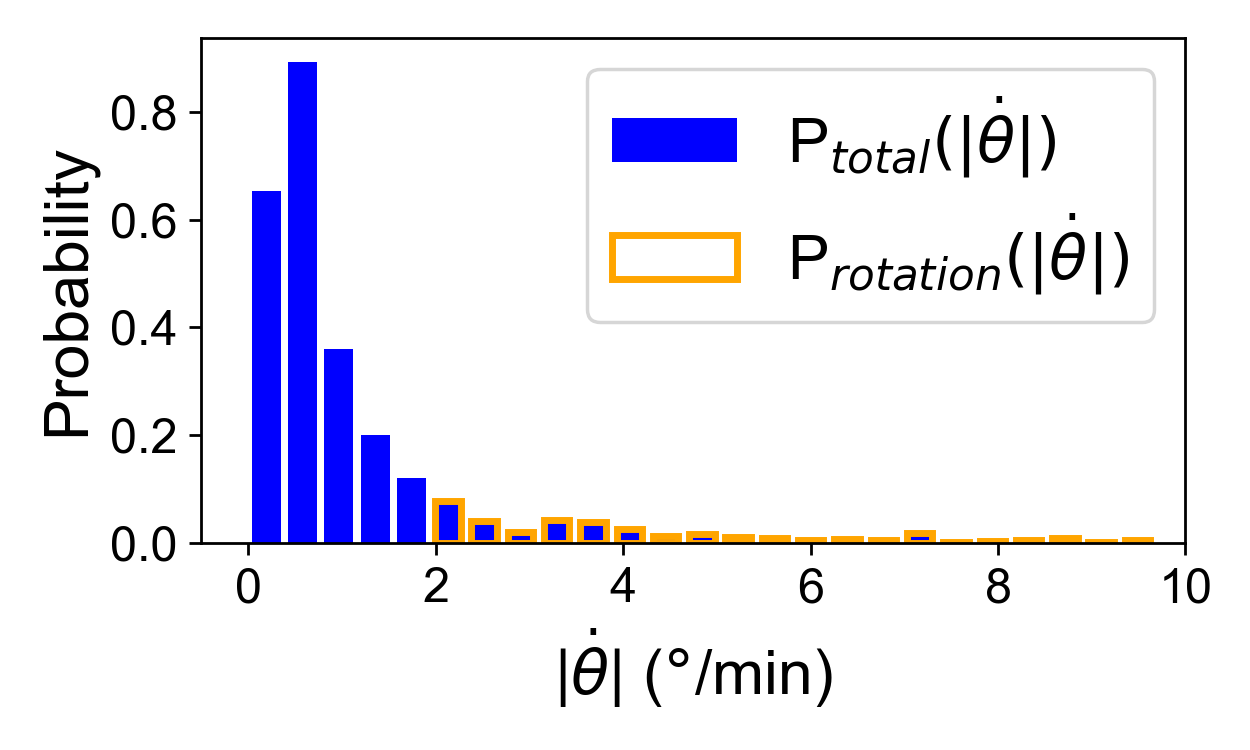

In [6]:
plt.figure(figsize = (5,3), dpi = 200)
n, bins, patches = plt.hist(grain_chain_info[:,1]/2.5,bins = 25,rwidth = 0.8,density = True, color='b',label  = "Total")
grain_chain_info_ = grain_chain_info[grain_chain_info[:,1]>1.95,1]
grain_chain_info_ = np.concatenate([grain_chain_info_, [24],[30 for i in grain_chain_info[grain_chain_info[:,1]<4.8,1]]])
n2, bins2, patches2 = plt.hist(grain_chain_info_/2.5,bins = np.concatenate([bins[5:],[35]]),rwidth = 0.7,fill=False,density = True, linewidth=2,edgecolor='orange',label  = r'$|\dot\theta|$>2'+u'$\u00b0$'+'/min')
plt.xlabel(r'|$\dot\theta$| ('+u'$\u00b0$'+'/min)',fontsize = 18)
plt.ylabel(r'Probability',fontsize = 18)
plt.xlim([-0.5,10])
plt.legend(fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

<IPython.core.display.Javascript object>


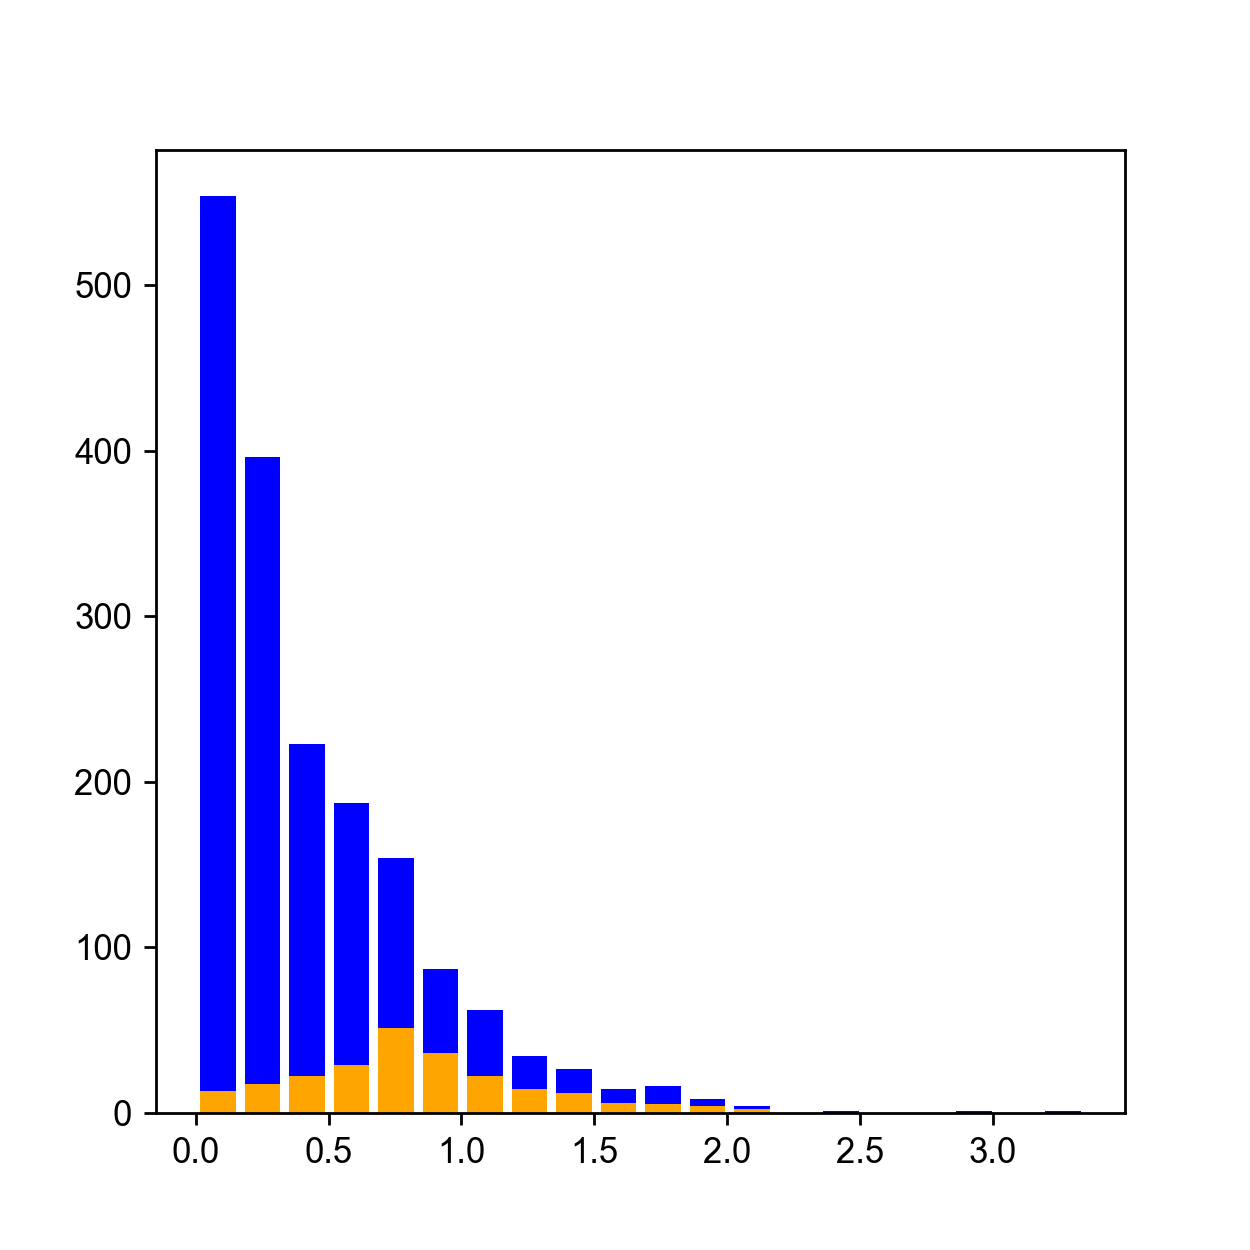

<IPython.core.display.Javascript object>


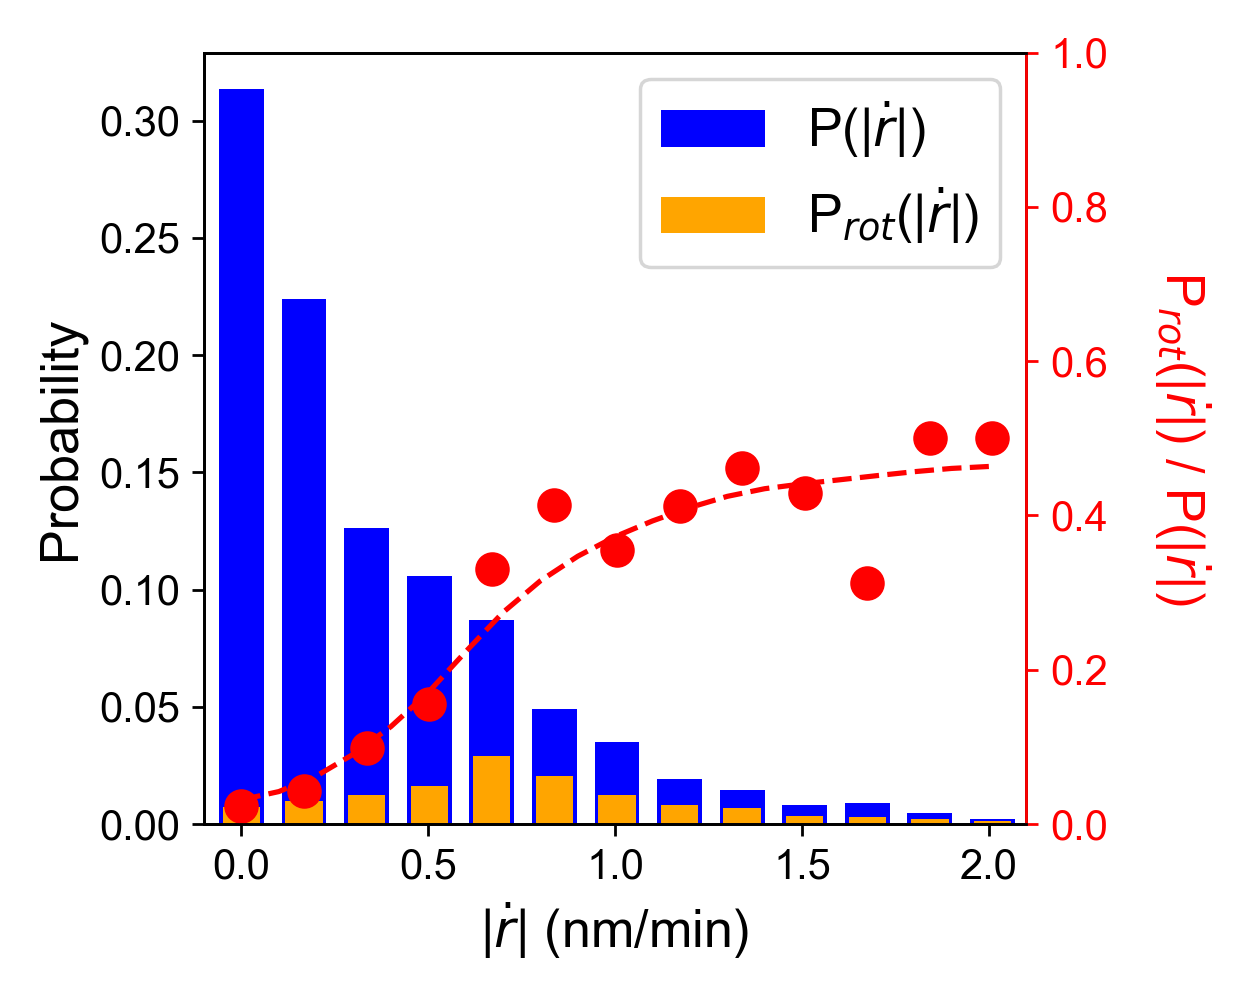

C:\Users\ytian\AppData\Local\Temp\ipykernel_24344\2470578560.py:15: RuntimeWarning: invalid value encountered in true_divide
  ax2.scatter(bins[:-1], n_2/n, s=80, c='r')


In [8]:
from scipy.interpolate import interp1d

grain_chain_info_abs = grain_chain_info
grain_chain_info_abs = abs(grain_chain_info_abs)
ori_thres = grain_chain_info_abs[:,1] > 5
fig, ax = plt.subplots(figsize = (5,5),dpi = 200)
n, bins, patches = ax.hist(grain_chain_info_abs[:,2],bins = 20,rwidth = 0.8, stacked=True,color='b',label = r'N(|$\Delta\theta$| < 5'+u"\u00b0)")
n_2, bins_2, patches_2 = ax.hist(grain_chain_info_abs[ori_thres,2],bins = bins,rwidth = 0.8,color='orange',label = r'N(|$\Delta\theta$| > 5'+u"\u00b0)")

fig, ax = plt.subplots(figsize = (5,4),dpi = 200)
ax.bar(bins[:-1],n/grain_chain_info.shape[0], width = 0.12, color='b',label = r"P(|$\dotr$|)")
ax.bar(bins_2[:-1],n_2/grain_chain_info.shape[0], width = 0.10,color='orange',label = r'P$_{rot}$(|$\dotr$|)')
plt.xlim([-0.1,2.3])
ax2 = ax.twinx()
ax2.scatter(bins[:-1], n_2/n, s=80, c='r')

data_2_x = bins[:13]
data_2 = (n_2/n)[:13]
data_2[-1] -= 0.02
data_2[-3] += 0.1
data_2[4] -= 0.05
data_2[:4] = gaussian_filter(data_2[:7],0.5)[:4]
data_2[4:] = gaussian_filter(data_2[2:],1.5)[2:]
data_2[-5:] = gaussian_filter(data_2[-5:],1.5)

f = interp1d(data_2_x, data_2)
xnew = np.arange(data_2_x[0], data_2_x[-1], 0.1)
ynew = f(xnew)
ynew = gaussian_filter(ynew,1)
ax2.plot(xnew, ynew, '--', c='r')
ax2.set_ylim([0,1])
ax2.set_xlim([-0.1,2.1])
# plt.yscale('log')
ax.set_xlabel(r'|$\dotr$| (nm/min)',fontsize = 15)
ax.set_ylabel(r'Probability',fontsize = 15)
ax2.set_ylabel(r'P$_{rot}$(|$\dotr$|) / P(|$\dotr$|)',fontsize = 15, c='r',rotation=-90,labelpad=30)
ax.tick_params(labelsize = 12)
ax2.tick_params(colors='red',labelsize = 12)
ax2.spines['right'].set_color('red')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='best', frameon=False)
ax.legend(fontsize = 15)
plt.tight_layout()
